# Project 3

In this project, you will perform a logistic regression on the admissions data we've been working with in projects 1 and 2.

In [68]:
# import modules 
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np
import seaborn as sns
%matplotlib inline

In [69]:
# load data
data = pd.read_csv("../assets/admissions.csv")
data.shape

(400, 4)

In [70]:
data.describe()

,admit,gre,gpa,prestige
count,400.000000,398.000000,398.00000,399.000000
mean,0.317500,588.040201,3.39093,2.486216
std,0.466087,115.628513,0.38063,0.945333
min,0.000000,220.000000,2.26000,1.000000
25%,0.000000,520.000000,3.13000,2.000000
50%,0.000000,580.000000,3.39500,2.000000
75%,1.000000,660.000000,3.67000,3.000000
max,1.000000,800.000000,4.00000,4.000000


In [27]:
# check missing values
data.dropna().count()

admit       397
gre         397
gpa         397
prestige    397
dtype: int64

In [28]:
# count missing values
data.isnull().sum()

admit       0
gre         2
gpa         2
prestige    1
dtype: int64

In [29]:
data[data['gre'].isnull()]

,admit,gre,gpa,prestige
187,0,NaN,NaN,2.0
212,0,NaN,2.87,2.0


In [30]:
data[data['gpa'].isnull()]

,admit,gre,gpa,prestige
187,0,NaN,NaN,2.0
236,1,660.0,NaN,NaN


In [31]:
data[data['prestige'].isnull()]


,admit,gre,gpa,prestige
236,1,660.0,NaN,NaN


In [8]:
#??? Question - how to show all rows with at least one missing value at one time?

In [32]:
# Method 1 - Create a dataset without missing values (only three missing values so I think it is ok to drop those.)
data_clean=data.dropna()
data_clean.shape

(397, 4)

In [78]:
# check average gre and gpa score level for each prestige
data.groupby('prestige')['gre','gpa'].mean()

,gre,gpa
prestige,,
1.0,611.803279,3.453115
2.0,596.621622,3.364027
3.0,574.876033,3.432893
4.0,570.149254,3.318358


In [97]:
# Method 2 - Create a dataset with filling missing values 
# filling prestige with mean
# filling gre and gpa with their column means by group of prestige colleges
# inspired by the article on how to deal with missing values shared by Nico
# https://chrisalbon.com/python/data_wrangling/pandas_missing_data/
data_fill = data.copy()
data_fill["prestige"].fillna(1.0, inplace=True)  #assigning prestige = 1 because gre=660
data_fill["gre"].fillna(data_fill.groupby('prestige')['gre'].transform('mean'), inplace=True)
data_fill["gpa"].fillna(data_fill.groupby('prestige')['gpa'].transform('mean'), inplace=True)
data_fill.isnull().sum()

admit       0
gre         0
gpa         0
prestige    0
dtype: int64

## Part 1. Frequency Tables

#### 1. Let's create a frequency table of our variables

prestige  1.0  2.0  3.0  4.0
admit                       
0          28   95   93   55
1          33   53   28   12


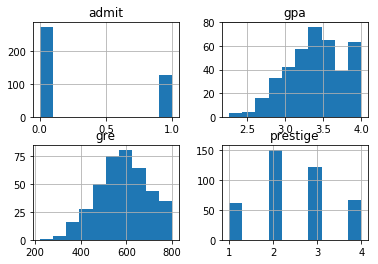

In [98]:
# Drop missing value table - frequency table for prestige and whether or not someone was admitted
prestige_freq = pd.crosstab(data_clean.admit, data_clean.prestige)
print(prestige_freq)
f=data.hist()

prestige  1.0  2.0  3.0  4.0
admit                       
0          28   97   93   55
1          34   53   28   12


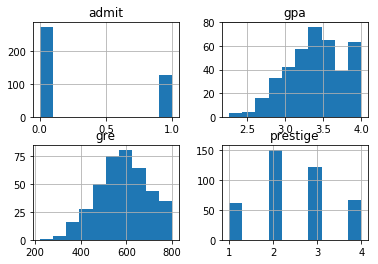

In [99]:
# Filling missing value table - frequency table for prestige and whether or not someone was admitted
prestige_freq = pd.crosstab(data_fill.admit, data_fill.prestige)
print(prestige_freq)
f=data.hist()

## Part 2. Return of dummy variables

##### No big difference is seen between dataset with dropping missing values and dataset with filling missing values. So I will use the dataset with filling missing values to run analysis. 

#### 2.1 Create class or dummy variables for prestige 

In [121]:
dummies = pd.get_dummies(data_fill.prestige,prefix='prestige')
df = pd.concat([data_fill,dummies],axis =1)
df.head()

,admit,gre,gpa,prestige,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
0,0,380.0,3.61,3.0,0,0,1,0
1,1,660.0,3.67,3.0,0,0,1,0
2,1,800.0,4.00,1.0,1,0,0,0
3,1,640.0,3.19,4.0,0,0,0,1
4,0,520.0,2.93,4.0,0,0,0,1


#### 2.2 When modeling our class variables, how many do we need? 



Answer: We only need three class variables because the fourth one can be determined by another three. Removing one class variable among total four class variables can avoid multicollinearity. The removed variable can be the base category against which other categories can be compared

## Part 3. Hand calculating odds ratios

Develop your intuition about expected outcomes by hand calculating odds ratios.

In [125]:
features = ['admit', 'gre', 'gpa']
handCalc = df[features].join(dummies.loc[:, 'prestige_1':])
handCalc.head()

,admit,gre,gpa,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
0,0,380.0,3.61,0,0,1,0
1,1,660.0,3.67,0,0,1,0
2,1,800.0,4.00,1,0,0,0
3,1,640.0,3.19,0,0,0,1
4,0,520.0,2.93,0,0,0,1


In [126]:
#crosstab prestige 1 admission 
# frequency table cutting prestige and whether or not someone was admitted
prestige1_freq = pd.crosstab(handCalc.admit, handCalc['prestige_1.0'])
prestige1_freq

prestige_1.0,0,1
admit,,
0,245,28
1,93,34


#### 3.1 Use the cross tab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college

In [127]:
odds_attend = 34/28
print(odds_attend)

1.2142857142857142


#### 3.2 Now calculate the odds of admission if you did not attend a #1 ranked college

In [128]:
odds_notattend = 93/245
print(odds_notattend)

0.3795918367346939


#### 3.3 Calculate the odds ratio

In [129]:
OR = odds_attend/odds_notattend
print(OR)

3.1989247311827955


#### 3.4 Write this finding in a sentenance: 

Answer: The odds of being admitted to the graduate school for students who attended top ranked colleges are three times the odds of being admitted to the graduate school for students who didn't. In other words, the odds of being admitted to graduate school are 2 times higher for students who attended a top ranked school compared to students who did not.

#### 3.5 Print the cross tab for prestige_4

In [130]:
prestige4_freq = pd.crosstab(handCalc.admit, handCalc['prestige_4.0'])
prestige4_freq

prestige_4.0,0,1
admit,,
0,218,55
1,115,12


#### 3.6 Calculate the OR 

In [131]:
OR = (12/55)/(115/218)
print(OR)

0.41359683794466406


#### 3.7 Write this finding in a sentence

Answer: The odds of being admitted to the graduate school for students who attended prestige 4 colleges were 60% lower than students who didn't attend

## Part 4. Analysis

In [132]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
datainput = df[cols_to_keep].join(dummies.loc[:, 'prestige_2':])
print (datainput.head())

   admit    gre   gpa  prestige_2.0  prestige_3.0  prestige_4.0
0      0  380.0  3.61             0             1             0
1      1  660.0  3.67             0             1             0
2      1  800.0  4.00             0             0             0
3      1  640.0  3.19             0             0             1
4      0  520.0  2.93             0             0             1


We're going to add a constant term for our Logistic Regression. The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.

In [135]:
# manually add the intercept
datainput['intercept'] = 1.0
datainput.head()


,admit,gre,gpa,prestige_2.0,prestige_3.0,prestige_4.0,intercept
0,0,380.0,3.61,0,1,0,1.0
1,1,660.0,3.67,0,1,0,1.0
2,1,800.0,4.00,0,0,0,1.0
3,1,640.0,3.19,0,0,1,1.0
4,0,520.0,2.93,0,0,1,1.0


#### 4.1 Set the covariates to a variable called train_cols

In [137]:
train_cols = datainput.columns[1:]
datainput[train_cols].head()

,gre,gpa,prestige_2.0,prestige_3.0,prestige_4.0,intercept
0,380.0,3.61,0,1,0,1.0
1,660.0,3.67,0,1,0,1.0
2,800.0,4.00,0,0,0,1.0
3,640.0,3.19,0,0,1,1.0
4,520.0,2.93,0,0,1,1.0


#### 4.2 Fit the model

In [138]:
model = sm.Logit(datainput.admit, datainput[train_cols])
result = model.fit()


Optimization terminated successfully.
         Current function value: 0.572794
         Iterations 6


#### 4.3 Print the summary results

In [139]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      394
Method:                           MLE   Df Model:                            5
Date:                Thu, 18 Jan 2018   Pseudo R-squ.:                 0.08349
Time:                        11:45:54   Log-Likelihood:                -229.12
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 6.644e-08
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
gre              0.0022      0.001      2.037      0.042    8.49e-05       0.004
gpa              0.7936      0.332      2.388      0.017       0.142       1.445
prestige_2.0    -0.7279      0.315     -2.310      0.021      -1.346      -0.110
prestige_3.0    -1.3693      0.344     -3.984      0.000      -2.043      -0.696
prestige_4.0    -1.5821      0.416     -3.799      0.000      -2.398      -0.766
intercept       -3.9045      1.142     -3.419      0.001      -6.143      -1.666
================================================================================
"""

#### 4.4 Calculate the odds ratios of the coeffiencents and their 95% CI intervals

hint 1: np.exp(X)

hint 2: conf['OR'] = params
        
           conf.columns = ['2.5%', '97.5%', 'OR']

In [140]:
result.params

gre             0.002232
gpa             0.793611
prestige_2.0   -0.727880
prestige_3.0   -1.369252
prestige_4.0   -1.582079
intercept      -3.904525
dtype: float64

In [141]:
np.exp(result.params)

gre             1.002234
gpa             2.211367
prestige_2.0    0.482932
prestige_3.0    0.254297
prestige_4.0    0.205547
intercept       0.020151
dtype: float64

In [186]:
confidence_interval = np.exp(result.conf_int())
confidence_interval.columns =['2.5%','97.5%']
confidence_interval['OR'] = np.exp(result.params)
confidence_interval

,2.5%,97.5%,OR
gre,1.000085,1.004388,1.002234
gpa,1.152919,4.241530,2.211367
prestige_2.0,0.260385,0.895685,0.482932
prestige_3.0,0.129658,0.498751,0.254297
prestige_4.0,0.090877,0.464912,0.205547
intercept,0.002149,0.188970,0.020151


#### 4.5 Interpret the OR of Prestige_2

Answer: The odds of being admitted to graduate school for students who attended prestige 2 colleges are 0.5 times the odds for students who attended top ranked colleges. In other words, the odds of being admitted for a student who attended prestige 2 colleges are 50% lower than students who attended top ranked colleges

#### 4.6 Interpret the OR of GPA

Answer: For one unit increase in gpa score, we expect to see about two times the odds of being admitted to the graduate school holding other variables constant.

## Part 5: Predicted probablities


As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called cartesian (above).

We're going to use np.linspace to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified min and maximum value--in our case just the min/max observed values.

In [144]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    m = int(m)
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [145]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
print (gres)
# array([ 220.        ,  284.44444444,  348.88888889,  413.33333333,
#         477.77777778,  542.22222222,  606.66666667,  671.11111111,
#         735.55555556,  800.        ])
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
print (gpas)
# array([ 2.26      ,  2.45333333,  2.64666667,  2.84      ,  3.03333333,
#         3.22666667,  3.42      ,  3.61333333,  3.80666667,  4.        ])


# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))
combos.columns=['gre', 'gpa', 'prestige', 'intercept']
combos.head()

[ 220.          284.44444444  348.88888889  413.33333333  477.77777778
  542.22222222  606.66666667  671.11111111  735.55555556  800.        ]
[ 2.26        2.45333333  2.64666667  2.84        3.03333333  3.22666667
  3.42        3.61333333  3.80666667  4.        ]


,gre,gpa,prestige,intercept
0,220.0,2.260000,1.0,1.0
1,220.0,2.260000,2.0,1.0
2,220.0,2.260000,3.0,1.0
3,220.0,2.260000,4.0,1.0
4,220.0,2.453333,1.0,1.0


#### 5.1 Recreate the dummy variables

In [151]:
# recreate the dummy variables
dummies = pd.get_dummies(combos['prestige'],prefix ='prestige')

# keep only what we need for making predictions
data = combos[['gre','gpa','intercept','prestige']].join(dummies.loc[:,'prestige_2.0':])
data.head()

,gre,gpa,intercept,prestige,prestige_2.0,prestige_3.0,prestige_4.0
0,220.0,2.260000,1.0,1.0,0,0,0
1,220.0,2.260000,1.0,2.0,1,0,0
2,220.0,2.260000,1.0,3.0,0,1,0
3,220.0,2.260000,1.0,4.0,0,0,1
4,220.0,2.453333,1.0,1.0,0,0,0


#### 5.2 Make predictions on the enumerated dataset

In [152]:
data['admit_pred'] = result.predict(data[train_cols])
data.tail(4)

,gre,gpa,intercept,prestige,prestige_2.0,prestige_3.0,prestige_4.0,admit_pred
396,800.0,4.0,1.0,1.0,0,0,0,0.741787
397,800.0,4.0,1.0,2.0,1,0,0,0.581126
398,800.0,4.0,1.0,3.0,0,1,0,0.422145
399,800.0,4.0,1.0,4.0,0,0,1,0.371263


#### 5.3 Interpret findings for the last 4 observations

Answer: Given the same gre score 800 and gpa score 4.0, the probability of being admitted to graduate school is positively correlated with prestige ranking - 74% probability of being admitted for studentis who attended prestige 1 college, 58% for prestige 2, 42% for prestige 3 and 37% for prestige 4. 

## Bonus

Plot the probability of being admitted into graduate school, stratified by GPA and GRE score.

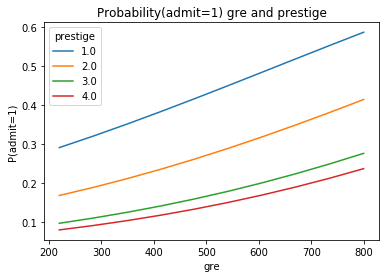

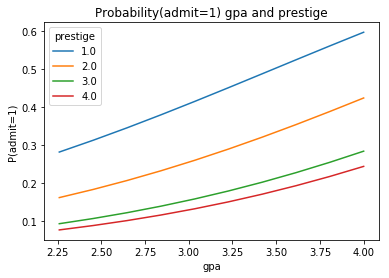

In [182]:
def prob_chart(variable):
    grouped = pd.pivot_table(data, index = [variable, 'prestige'], values =['admit_pred'], aggfunc = np.mean)
    for col in data.prestige.unique():
        plot_data = grouped[grouped.index.get_level_values(1)==col]
        plt.plot(plot_data.index.get_level_values(0), plot_data['admit_pred'])
    f=plt.legend(data.prestige.unique(), loc='upper left', title = 'prestige')
    f=plt.xlabel(variable)
    f=plt.ylabel('P(admit=1)')
    f=plt.title('Probability(admit=1) '+variable+" and prestige")
    plt.show()


prob_chart('gre')
prob_chart('gpa')